# Project Image Processing 2021
**Author : Verardo Luca, Fridez Lucas & Dos Santos Ferreira Julien**

**Course : 3252 - Image Processing**

**Profesor : M. Tièche**

This notebook contain the entire of project.

To use this notebook please refer to user documentation.

## Watershed algorithm

### Imports

In [1]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os, subprocess

### Function to show image

In [2]:
def show(img,title):
    plt.imshow(img)
    plt.title(title)
    plt.show()

### Watershed algorithm and counting

In [ ]:
#Import and transformation of src image
img_path = '../dataset/training/image-10.png'

img = cv2.imread(img_path)
show(img,"Image originale")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(img,127, 255, cv2.THRESH_BINARY_INV)
show(binary, "Binaire")

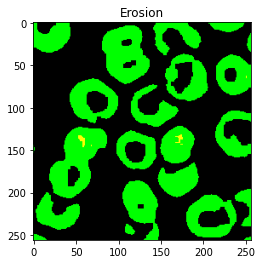

In [50]:
#Morphologic transformations
kernel = np.ones((5,5),np.uint8)

erosion = cv2.erode(binary,kernel,iterations = 1)
dilation = cv2.dilate(binary,kernel,iterations = 1)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

show(erosion, "Erosion")
# show(dilation, "Dilatation")
# show(opening, "Ouverture")
# show(closing, "Fermeture")

<ipython-input-51-ee0bd32edd67>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=40, labels=thr)


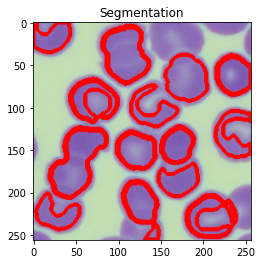

Number of blood cells segments detected =  14


In [51]:
# preprocessing the image
hsv = cv2.cvtColor(erosion, cv2.COLOR_BGR2HSV)
# show(hsv,"HSV")

h, s, v = cv2.split(hsv)
# show(s, "Saturation")

_, thr = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# show(thr, "Threshold")

kernel_size = 5

blur = cv2.medianBlur(thr, kernel_size)
# show(blur, "Blur")

area_min = 1000

contours, hierarchy = cv2.findContours(
    blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
count = []
for x in contours:
    area = cv2.contourArea(x)
    if area > area_min:
        count.append(x)

D = ndimage.distance_transform_edt(thr)
localMax = peak_local_max(D, indices=False, min_distance=40, labels=thr)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thr)
ws = len(np.unique(labels)) - 1

#Count number of segmentation
ans = int((ws + len(count)) /2)
cv2.drawContours(img, count, -1, (255, 0, 0), 3)
show(img, "Segmentation")
print("Number of blood cells segments detected = ", len(count))

## YOLOv5

### Inference
To launch correctly this section please refer to user documentation

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='/tmp/temp_detect', save_conf=False, save_txt=False, source='/tmp/todetect', update=False, view_img=False, weights=['../best.pt'])
Fusing layers... 
image 1/1 /tmp/todetect/image.png: 640x640 25 Red Blood Cells, Done. (0.060s)
Results saved to /tmp/temp_detect/exp
Done. (0.127s)



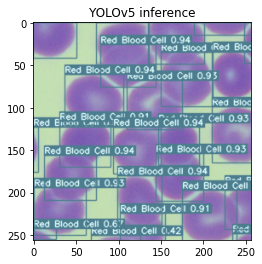

In [4]:
# Process the same image in YOLOv5
temp_dir = "/tmp/todetect/"
yolo_project_dir = "/tmp/temp_detect"
os.system("rm -rf " + temp_dir + " " + yolo_project_dir)
os.system("mkdir " + temp_dir )
os.system("cp " + img_path + " /tmp/todetect/image.png")

result = subprocess.check_output("python3 ../detect.py --weights ../best.pt --source /tmp/todetect --project /tmp/temp_detect", shell=True)
print(result.decode("utf-8"))

yolo_img = cv2.imread("/tmp/temp_detect/exp/image.png")
show(yolo_img, "YOLOv5 inference")